
## **🦟 Malaria Cell Classification**


**1. Problem Statement**

Malaria is a life-threatening disease that affects millions worldwide, especially in tropical and developing regions. Traditional detection requires manual inspection of blood smears under a microscope, which is time-consuming and prone to human error.

**Goal:** To build an AI-powered model that can classify whether a given blood cell image is infected or uninfected with malaria parasites using deep learning.

**2. Uploading Data**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Importing Libraries**

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os, zipfile
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


**4. Dataset Paths**

In [44]:
zip_path = "/content/drive/MyDrive/Malaria_Project/Malaria_dataset.zip"
extract_path = "/content/Malaria_dataset/Malaria_dataset"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    print("Dataset extracted")

train_path = os.path.join(extract_path, "train")
test_path = os.path.join(extract_path, "test")


**5. Image Data Generators**

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='binary')

Found 27558 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.


**6. Model Architecture (ResNet50 Transfer Learning)**

In [46]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [47]:
#Callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

**7. Train Model**

In [48]:
history = model.fit(train_set, validation_data=test_set, epochs=5, callbacks=[checkpoint, early_stop])


Epoch 1/5
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5289 - loss: 0.6894

862/862 ━━━━━━━━━━━━━━━━━━━━ 461s 522ms/step - accuracy: 0.5289 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6814
Epoch 2/5
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5944 - loss: 0.6714

862/862 ━━━━━━━━━━━━━━━━━━━━ 423s 491ms/step - accuracy: 0.5944 - loss: 0.6714 - val_accuracy: 0.5579 - val_loss: 0.6663
Epoch 3/5
862/862 ━━━━━━━━━━━━━━━━━━━━ 420s 487ms/step - accuracy: 0.6094 - loss: 0.6632 - val_accuracy: 0.5471 - val_loss: 0.6763
Epoch 4/5
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6270 - loss: 0.6553

862/862 ━━━━━━━━━━━━━━━━━━━━ 439s 484ms/step - accuracy: 0.6270 - loss: 0.6553 - val_accuracy: 0.5643 - val_loss: 0.6666
Epoch 5/5
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6214 - loss: 0.6534

862/862 ━━━━━━━━━━━━━━━━━━━━ 415s 481ms/step - accuracy: 0.6214 - loss: 0.6534 - val_accuracy: 0.6108 - val_loss: 0.6446


**8. Results & Visualization**


 Plots training accuracy/loss curves



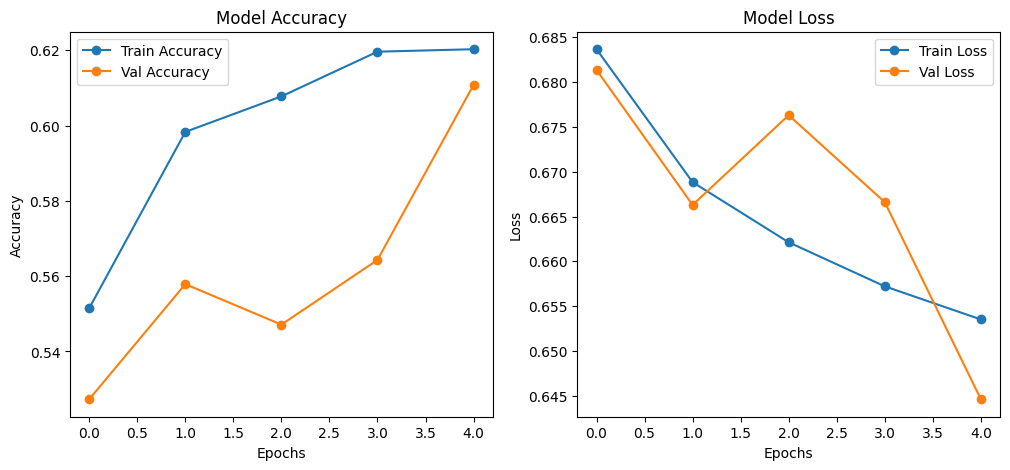

In [55]:
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


 Visualize Predictions on a Batch of Images






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


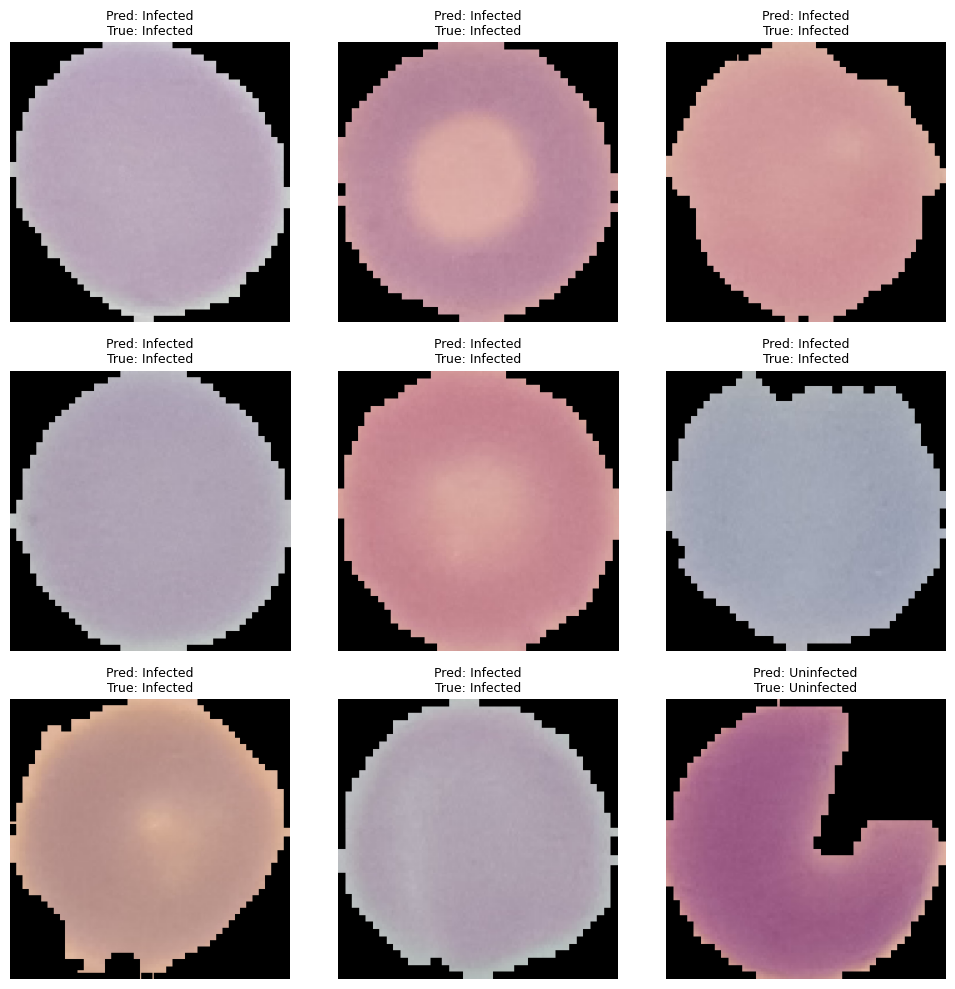

In [62]:
images, labels = next(test_set)
preds = model.predict(images)
pred_labels = (preds > 0.5).astype("int")

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    title = f"Pred: {'Infected' if pred_labels[i]==1 else 'Uninfected'}\nTrue: {'Infected' if labels[i]==1 else 'Uninfected'}"
    plt.title(title, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

**9. Save Model**

In [60]:
model.save("/content/drive/MyDrive/Malaria_Project/malaria_model_resnet50.h5")
print("Model saved to Drive!")

Model saved to Drive!
